In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from timeit import timeit
from joblib import dump, load

from sklearn.metrics import classification_report, plot_confusion_matrix, balanced_accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split, KFold, RepeatedStratifiedKFold
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans

from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline

import xgboost

/Users/brianroepke/miniforge3/envs/ML/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv("bank.csv", delimiter=";")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [4]:
# check for nan/null
df.isnull().values.any()

False

In [5]:
# drop duplicates
len(df.drop_duplicates())

4521

In [6]:

# duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
df.drop(columns='duration', inplace=True)

In [20]:
X = df.iloc[:, :-1]
y = df.iloc[:,-1]

In [21]:
enc = LabelEncoder()
enc.fit(y)
y = enc.transform(y)

In [22]:
column_trans = ColumnTransformer(transformers=
        [('num', MinMaxScaler(), selector(dtype_exclude="object")),
        ('cat', OrdinalEncoder(), selector(dtype_include="object"))],
        remainder='drop')

In [46]:
# get a list of models to evaluate
def get_models():
    models = dict()
    
    # Decision Tree
    models['LogReg'] = Pipeline([('prep', column_trans), ('model', LogisticRegression(random_state=42, max_iter=1000))])
    models['DTree'] = Pipeline([('prep', column_trans), ('model', DecisionTreeClassifier(random_state=42))])
    models['RandForest'] = Pipeline([('prep', column_trans), ('model', RandomForestClassifier(random_state=42))])
    models['Extra'] = Pipeline([('prep', column_trans), ('model', ExtraTreesClassifier(random_state=42))])
    models['GradBoost'] = Pipeline([('prep', column_trans), ('model', GradientBoostingClassifier(random_state=42))])
    models['AdaBoost'] = Pipeline([('prep', column_trans), ('model', AdaBoostClassifier(random_state=42))]) 
    models['XGB'] = Pipeline([('prep', column_trans), ('model', xgboost.XGBRegressor(objective ='reg:linear', verbosity = 0, random_state=42))]) 
    models['SGD'] = Pipeline([('prep', column_trans), ('model', SGDClassifier(random_state=42))])
    models['NN'] = Pipeline([('prep', column_trans), ('model', KNeighborsClassifier(3))])
    models['Perceptron'] = Pipeline([('prep', column_trans), ('model', Perceptron(random_state=42))])
    return models

In [47]:
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    global scores
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    return scores

CPU times: user 26.8 ms, sys: 3.65 ms, total: 30.4 ms
Wall time: 1.6 s
* LogReg Score = 0.679 StdDev = (0.020) 

CPU times: user 26.9 ms, sys: 3.1 ms, total: 30 ms
Wall time: 71.2 ms
* DTree Score = 0.582 StdDev = (0.018) 

CPU times: user 32.7 ms, sys: 3.57 ms, total: 36.3 ms
Wall time: 531 ms
* RandForest Score = 0.736 StdDev = (0.017) 

CPU times: user 34.8 ms, sys: 3.66 ms, total: 38.4 ms
Wall time: 429 ms
* Extra Score = 0.711 StdDev = (0.018) 

CPU times: user 32.5 ms, sys: 4.41 ms, total: 36.9 ms
Wall time: 702 ms
* GradBoost Score = 0.744 StdDev = (0.020) 

CPU times: user 31.3 ms, sys: 3.77 ms, total: 35.1 ms
Wall time: 233 ms
* AdaBoost Score = 0.733 StdDev = (0.019) 

CPU times: user 29.5 ms, sys: 3.17 ms, total: 32.7 ms
Wall time: 13.6 s
* XGB Score = 0.702 StdDev = (0.020) 

CPU times: user 28.4 ms, sys: 3.34 ms, total: 31.7 ms
Wall time: 78.5 ms
* SGD Score = 0.615 StdDev = (0.038) 

CPU times: user 27.3 ms, sys: 3.14 ms, total: 30.4 ms
Wall time: 51.6 ms
* NN Score = 0.6

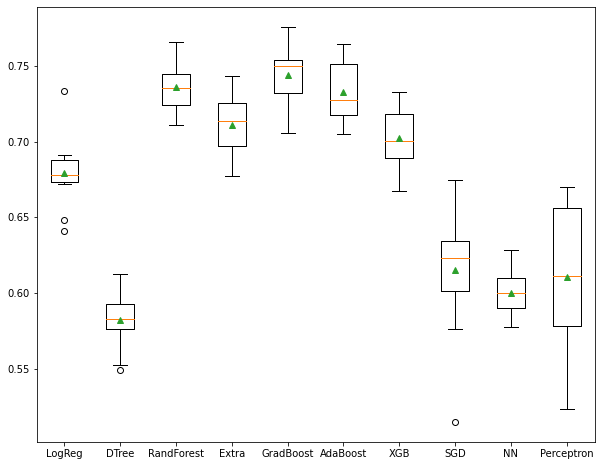

In [48]:
# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    %time scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('* %s Score = %.3f StdDev = (%.3f)' % (name, np.mean(scores), np.std(scores)), '\n')

# plot model performance for comparison
plt.figure(figsize=(10,8))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()